In [1]:
!git clone https://github.com/yarathealmighty/dumps.git

Cloning into 'dumps'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 246 (delta 34), reused 30 (delta 11), pack-reused 183 (from 1)
Receiving objects: 100% (246/246), 112.42 MiB | 10.69 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Updating files: 100% (26/26), done.


In [2]:
!pip install transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is 

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import dumps.utils as utils
import matplotlib.pyplot as plt
import re
from collections import Counter
import xgboost as xgb

In [4]:
def preprocess_function(examples):
    label = examples["score"]
    examples = tokenizer(examples["question"],examples['answer'], truncation=True, padding="max_length", max_length=256)

    examples["label"] = float(label)
    return examples

def compute_metrics(eval_pred):
    #copied code
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

def compute_metrics_for_regression(eval_pred):
    #copied code
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()

    # Compute accuracy
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.5]) / len(single_squared_errors)

    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}

def to_ds(df_og,debug_mode=False):
  # get trios
  df = utils.get_qas(df_og)

  # normalize and drop empty rows
  if debug_mode:
    df = utils.normalize_scores(df,False)
    df = df[df['normalized_score'].notna()]

  else:
    df = utils.normalize_scores(df)
    df = df[df['score'].notna()]

  #se as in StackExchange
  se = Dataset.from_pandas(df)
  train_test_split = se.train_test_split(test_size=0.2, seed=42)

  # turn it into train/test datasetdict
  se = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
  })

  # prepare q and a for training
  for split in se:
    se[split] = se[split].map(preprocess_function, remove_columns=["score",'__index_level_0__'])

  return se

def get_qc_feature(df):
  all_questions_list = []
  all_answer_list = []
  # iteration, getting each sentence and checking if that sentence is a question
  for _, row in df.iterrows():
    question = row['question']
    answer = row['answer']
    sentences = utils.get_sentences(question)
    answers = utils.get_sentences(answer)
    questions = utils.get_question_sentences(sentences)
    all_questions_list.append(questions)
    all_answer_list.append(answers)
  df['question_sentences'] = all_questions_list
  df['answer_sentences'] = all_answer_list
  return df

def classify_question_type(question):
    # brute force question classification
    question = question.lower().strip()
    if question.startswith("what"):
        return "what"
    elif question.startswith("how"):
        return "how"
    elif question.startswith("why"):
        return "why"
    elif question.startswith(("is", "are", "was", "were", "do", "does", "did")):
        return "yes/no"
    elif question.startswith("when"):
        return "when"
    elif question.startswith("who"):
        return "who"
    elif question.startswith("where"):
        return "where"
    else:
        return "other"

def get_q_a_types(df,leave_sentences_in=False):
  if 'question_sentences' not in df.columns or 'answer_sentences' not in df.columns:
    df = get_qc_feature(df)
  question_types = []
  answer_types = []
  # brute force question classification yet again
  for _, row in df.iterrows():
    questions = row['question_sentences']
    answers = row['answer_sentences']
    q_types = []
    a_types = []
    for question in questions:
      q_types.append(classify_question_type(question))
    question_types.append(q_types)
    for answer in answers:
      a_types.append(classify_answer_type(answer))
    answer_types.append(a_types)
  df['question_types'] = question_types
  df['answer_types'] = answer_types
  if not leave_sentences_in:
    df = df.drop(columns=['question_sentences','answer_sentences'])
  return df

def classify_answer_type(answer):
    answer = answer.lower().strip()
    if answer.startswith(("yes", "no")):
        return "yes/no"
    elif "because" in answer or "since" in answer:
        return "explanation"
    elif re.search(r'\b\d{1,2}:\d{2}\b|\b(am|pm)\b', answer):
        return "time"
    else:
        return "other"

def get_q_a_match_num(df,leave_types_in=False):
    q_a_matches = []
    # not proud of it but it works (for now)
    for _, row in df.iterrows():
      counter = 0
      questions = row['question_types']
      answers = row['answer_types']
      for question in questions:
        for answer in answers:
          if question == 'what' and answer == 'other':
            counter+=1
          elif question == 'how' and answer == 'explanation':
            counter+=1
          elif question == 'why' and answer == 'explanation':
            counter+=1
          elif question == 'yes/no' and answer == 'yes/no':
            counter+=1
          elif question == 'when' and answer == 'time':
            counter+=1
          elif question == 'who' and answer == 'other':
            counter+=1
          elif question == 'where' and answer == 'other':
            counter+=1
      q_a_matches.append(counter)
    df['q_a_matches'] = q_a_matches
    if not leave_types_in:
      df = df.drop(columns=['question_types','answer_types'])
    return df

In [5]:
#--------------------------------------<paths>---------------------------------------------

FILENAME = 'beer.csv'

#--------------------------------------<model_params>--------------------------------------

BASE_MODEL = "distilbert/distilbert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

#------------------------------------------------------------------------------------------

In [6]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# using <insert current stack exchange forum here> SE here
df = pd.read_csv('dumps/data/parsed/' + FILENAME)
se = to_ds(df)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

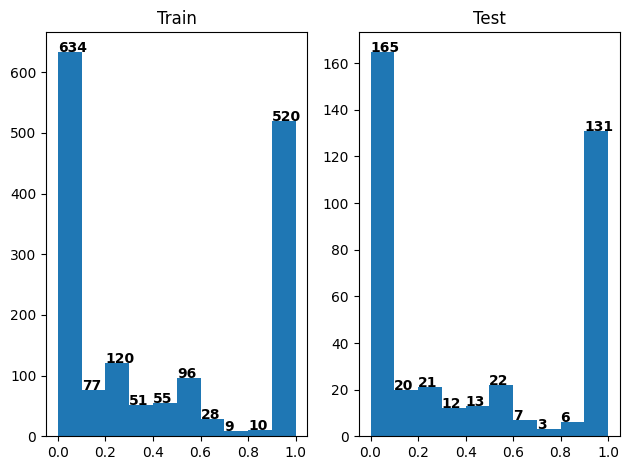

In [8]:
fig, axs = plt.subplots(1, 2, tight_layout=True)
distributions = []

axs[0].set_title("Train"); axs[1].set_title("Test");
train_distributions = axs[0].hist(se['train']["label"], bins=10)
test_distributions = axs[1].hist(se['test']["label"], bins=10)

for distributions, ax in zip([train_distributions, test_distributions], axs):
    for j in range(10):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")

In [9]:
training_args = TrainingArguments(
    output_dir="models/distilbert/"+FILENAME[:-4],
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=20,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

In [10]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [11]:
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=se["train"],
    eval_dataset=se["test"],
    compute_metrics=compute_metrics_for_regression,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,No log,0.190527,0.190527,0.403718,0.002819,0.987500
2,No log,0.187825,0.187825,0.394330,0.016960,0.965000
3,No log,0.193771,0.193771,0.392985,-0.014156,0.942500
4,No log,0.225008,0.225008,0.401276,-0.177648,0.865000
5,0.146000,0.252556,0.252556,0.417331,-0.321828,0.807500
6,0.146000,0.256691,0.256691,0.413004,-0.343468,0.795000
7,0.146000,0.293004,0.293004,0.435443,-0.533521,0.762500
8,0.146000,0.277225,0.277225,0.421992,-0.450938,0.760000
9,0.146000,0.251339,0.251339,0.411269,-0.315457,0.795000
10,0.023300,0.251280,0.251280,0.402865,-0.315148,0.790000


TrainOutput(global_step=2000, training_loss=0.04590070056915283, metrics={'train_runtime': 874.8614, 'train_samples_per_second': 36.577, 'train_steps_per_second': 2.286, 'total_flos': 2119440580608000.0, 'train_loss': 0.04590070056915283, 'epoch': 20.0})

In [12]:
trainer.eval_dataset=se["test"]
eval = trainer.evaluate()

EVAL_FILENAME = "eval_"+FILENAME[:-4]+".txt"

with open(EVAL_FILENAME, "w") as file:
    file.write(str(eval))
    file.close()

In [14]:
df = pd.read_csv('dumps/data/parsed/' + FILENAME)
df = utils.get_qas(df)
df = utils.normalize_scores(df)
df = df[df['score'].notna()]

df = utils.get_cw_feature(df)

# what/how/why/yes/no/when/who/where classification
# brute force, cannot classify complex questions for now
# need a better solution for classifying answers (might use a NN here)
df = get_q_a_types(df)
# df = get_q_a_match_num(df)

In [15]:
#se as in StackExchange
se = Dataset.from_pandas(df)
train_test_split = se.train_test_split(test_size=0.2, seed=42)

# turn it into train/test datasetdict
se = DatasetDict({
  'train': train_test_split['train'],
  'test': train_test_split['test']
})

# prepare q and a for training
for split in se:
  se[split] = se[split].map(preprocess_function, remove_columns=["score",'__index_level_0__'])

train_dataset = se['train']
test_dataset = se['test']

# tokenize q + a
X_train = [tokenizer(example['question'],example['answer'], truncation=True, padding="max_length", max_length=256)['input_ids'] for example in train_dataset]
y_train = [example['label'] for example in train_dataset]

X_test = [tokenizer(example['question'],example['answer'], truncation=True, padding="max_length", max_length=256)['input_ids'] for example in test_dataset]
y_test = [example['label'] for example in test_dataset]

# train
regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5)
regressor.fit(X_train, y_train)

# predict + mse
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Mean Squared Error: 0.23543750381308035


In [ ]:
# early modellek kiértékelése
# extra feautrek

In [ ]:
# ----------------------------------------------------------<HF params>----------------------------------------------------------

model_repo_id = 'yarathealmighty/test-movies'
ds_repo_id = 'yarathealmighty/dumps'
access_token = 'hf_yourtoken'

# --------------------------------------------------------<HF code below>--------------------------------------------------------

from huggingface_hub import HfApi

api = HfApi()

api.upload_folder(
    folder_path="models/distilbert/"+FILENAME[:-4],
    repo_id=model_repo_id,
    repo_type="model",
    token=access_token
)

se['train'].push_to_hub(
    'yarathealmighty/dumps',
    'train',
    token=access_token
)
se['test'].push_to_hub(
    'yarathealmighty/dumps',
    'test',
    token=access_token
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

Upload 99 LFS files:   0%|          | 0/99 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/536M [00:00<?, ?B/s]

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

events.out.tfevents.1725960383.dcee7a4ae5ef.754.0:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

events.out.tfevents.1725961007.dcee7a4ae5ef.754.1:   0%|          | 0.00/4.18k [00:00<?, ?B/s]

events.out.tfevents.1725961185.dcee7a4ae5ef.4273.0:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

events.out.tfevents.1725971139.dcee7a4ae5ef.4273.1:   0%|          | 0.00/560 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/20 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/876 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/yarathealmighty/dumps/commit/95ac892c6ec6af3242d2ad405a4eb47040e11163', commit_message='Upload dataset', commit_description='', oid='95ac892c6ec6af3242d2ad405a4eb47040e11163', pr_url=None, pr_revision=None, pr_num=None)